# First preliminary analysis of the proteomic data

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster
from sklearn.preprocessing import StandardScaler


In [27]:
## download the raw and the normalized signal data 

raw_data = pd.read_csv("./inputs/proteomics_data/raw_concentration.csv", sep=',')
norm_signal = pd.read_csv("./inputs/proteomics_data/normalized_signal.csv", sep=',')   

In [28]:
## we remplace the value of ULOD by 99999 in the raw data to calcule the number of missing values
raw_data.replace(">ULOD", 99999, inplace=True)

In [29]:
protein_cols = [col for col in raw_data.columns 
                if not str(col).strip().lower().startswith("metadata")]

print("Protein columns", proteine_cols)
print("Number of protein columns:", len(proteine_cols))

Protein columns ['P08476', 'O14672', 'P78536', 'Q9UKQ2', 'Q13443', 'Q9UHI8', 'Q9UNA0', 'Q15848', 'Q9UNG2', 'Q15389', 'Q9Y5C1', 'Q9BY76', 'O43827', 'P05067', 'O75888', 'P15514', 'Q9Y275', 'Q02223', 'P12643', 'P12645', 'P12644', 'P22004', 'P18075', 'Q9UK05', 'Q96GW7', 'P01031', 'P05937', 'P51671', 'Q99616', 'Q16627', 'Q16663', 'O15467', 'Q92583', 'P55774', 'Q99731', 'P13500', 'P78556', 'O00585', 'P55773', 'O00175', 'O15444', 'Q9Y4X3', 'Q9NRJ3', 'P10147', 'P13236', 'P13501', 'P80098', 'P08571', 'Q86VB7', 'Q9NNX6', 'Q5ZPR3', 'P32970', 'P29965', 'P33681', 'P42081', 'P36222', 'P23946', 'Q9UBD9', 'P26441', 'P02741', 'P78423', 'P09341', 'P02778', 'O14625', 'P48061', 'P48061.1', 'O43927', 'O95715', 'Q9H2A7', 'Q6UXB2', 'P19876', 'P02776', 'P42830', 'P80162', 'P02775', 'Q07325', 'P99999', 'P07585', 'P27487', 'Q93038', 'O00220', 'O75509', 'Q16610', 'P01133', 'P00533', 'P08246', 'P35613', 'P17813', 'P16581', 'P25445', 'P48023', 'Q9UGM5', 'P05230', 'O95750', 'P09038', 'Q9NSA1', 'P08620', 'P10767', '

In [30]:
## counting the missing values in the raw data (LLOD)
def count_non_numeric(col):
    return (~col.astype(str).str.replace(".", "", regex=False).str.isnumeric()).mean() * 100

protein_cols = [col for col in raw_data.columns if not col.startswith("Metadata")]

missing_percent_df = pd.DataFrame(index=protein_cols, columns=raw_data["Metadata_Compound"].unique())

for protein in protein_cols:
    for compound in raw_data["Metadata_Compound"].unique():

        compound_data = raw_data[raw_data["Metadata_Compound"] == compound]
        missing_percent = count_non_numeric(compound_data[protein])
        missing_percent_df.loc[protein, compound] = missing_percent

# dataphrame with the missing values Protein vs Compound
print(missing_percent_df)

       UNTREATED Actinomycin D Bevirimat Ethoxyquin TC-S 7004 Amperozide  \
P08476     100.0         100.0     100.0      100.0     100.0      100.0   
O14672     98.75          95.0     100.0      100.0     100.0      100.0   
P78536     100.0          90.0     100.0      100.0     100.0      100.0   
Q9UKQ2     100.0         100.0     100.0      100.0     100.0      100.0   
Q13443      97.5          85.0     100.0      100.0     100.0      100.0   
...          ...           ...       ...        ...       ...        ...   
Q9Y5W5     100.0          90.0     100.0      100.0     100.0      100.0   
O95388     100.0         100.0     100.0      100.0     100.0       95.0   
P56704     100.0         100.0     100.0      100.0     100.0      100.0   
P41221     96.25         100.0      95.0       95.0     100.0       95.0   
P47992     100.0         100.0     100.0      100.0     100.0      100.0   

       IOPANOIC ACID Treprostinil MILTEFOSINE  Lys05  ...  \
P08476         100.0      

In [31]:
## list of 35 proteins that are fully missing in all compounds

proteins_fully_missing = missing_percent_df.index[(missing_percent_df == 100).all(axis=1)]
print(proteins_fully_missing)

Index(['P08476', 'Q9UKQ2', 'Q9UNG2', 'P12643', 'Q99616', 'O15444', 'P80162',
       'P17813', 'P05230', 'P10767', 'P21781', 'P22607', 'P36888', 'O00182',
       'P01563', 'P01574', 'Q08334', 'Q96PD4', 'Q14116', 'P27930', 'Q8IU54',
       'P01589', 'Q14213', 'P05112', 'P05113', 'P13232', 'P14151', 'P14780',
       'P07204', 'Q02763', 'Q969D9', 'P00749', 'P17948', 'Q9H7M9', 'P56704'],
      dtype='object')


<Figure size 1500x2500 with 0 Axes>

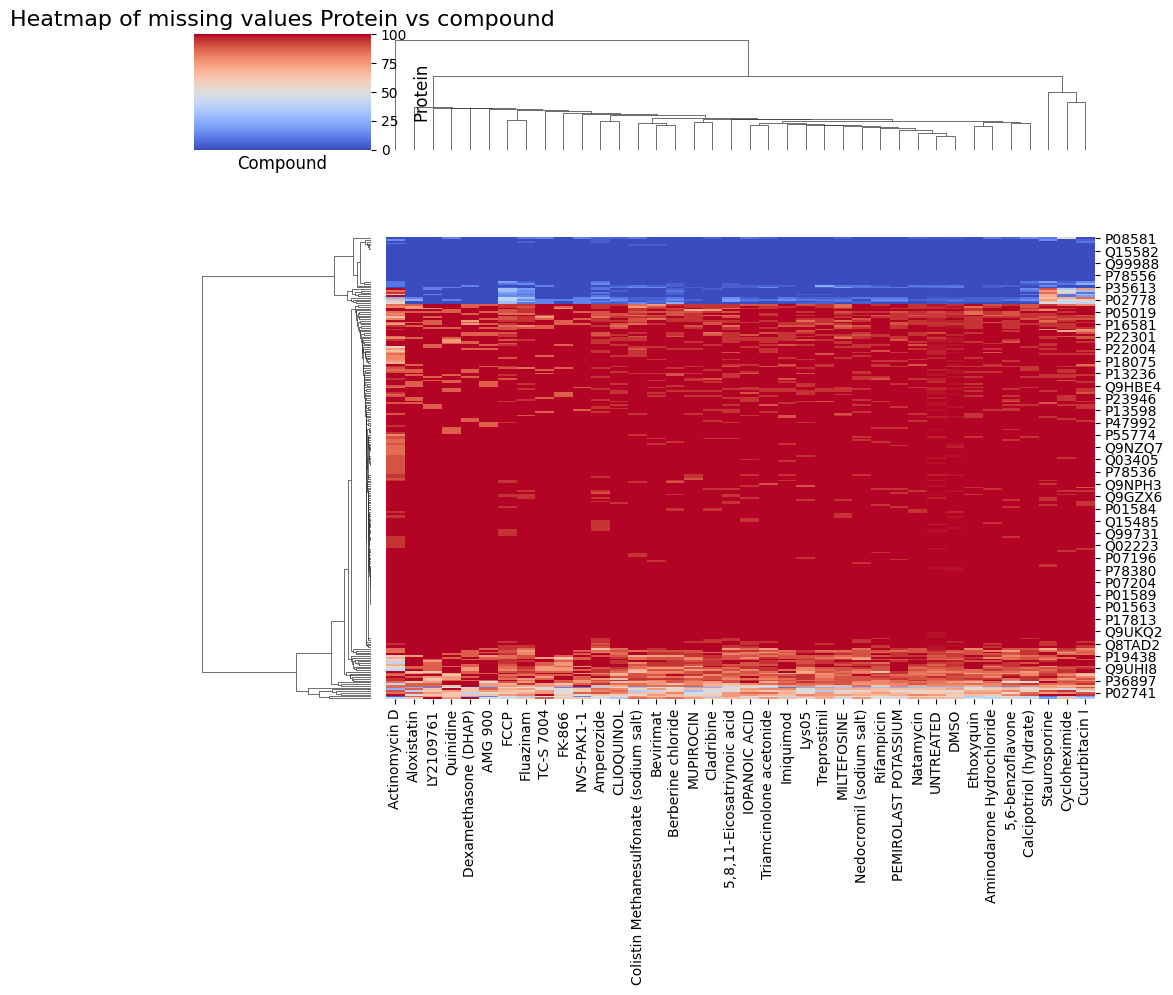

In [32]:
# heatmap of missing values Protein vs Compound

plt.figure(figsize=(15, 25)) 
sns.clustermap(missing_percent_df.astype(float), annot=False, cmap="coolwarm", fmt=".2f", 
            cbar_kws={'label': 'Percentage (%)'})


plt.title("Heatmap of missing values Protein vs compound", fontsize=16)
plt.xlabel("Compound", fontsize=12)
plt.ylabel("Protein", fontsize=12)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

We do the same heatmap of the missing LLOD values for the DMSO data across different wells.

<Figure size 2000x1800 with 0 Axes>

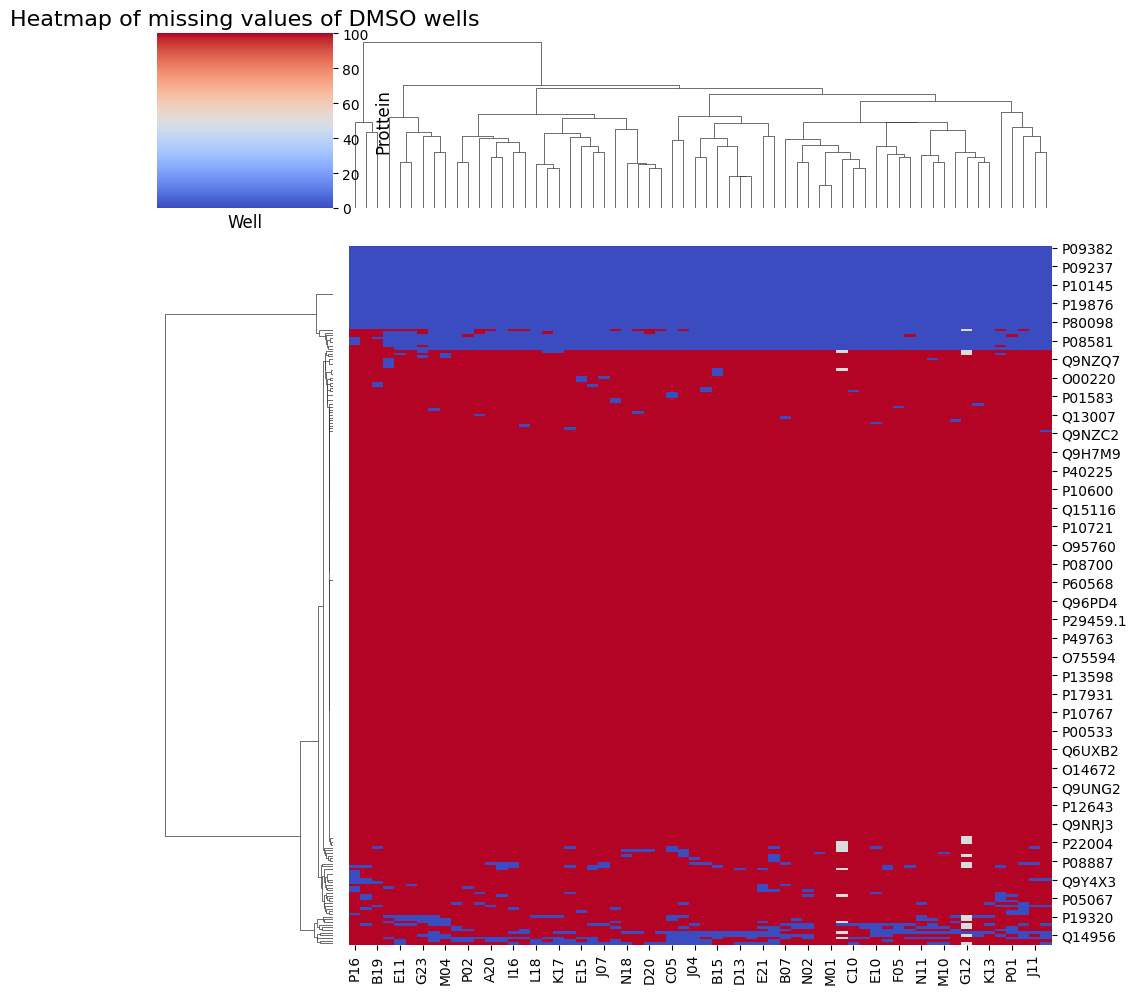

In [33]:
dmso_data = raw_data[raw_data['Metadata_Compound'] == 'DMSO']

proteine_cols = [col for col in dmso_data.columns if not col.startswith("Metadata")]
missing_percent_dmso = pd.DataFrame(index=proteine_cols, columns=dmso_data["Metadata_well_id"].unique())


for protein in proteine_cols:
    for well in dmso_data["Metadata_well_id"]:
       
        well_data = dmso_data[dmso_data["Metadata_well_id"] == well]
     
        non_numeric_percent = (~well_data[protein].astype(str).str.replace(".", "", regex=False).str.isnumeric()).mean() * 100
        missing_percent_dmso.loc[protein, well] = non_numeric_percent

missing_percent_dmso = missing_percent_dmso.astype(float)

plt.figure(figsize=(20, 18))  
sns.clustermap(missing_percent_dmso, annot=False, cmap="coolwarm", 
               method='ward', cbar_kws={'label': 'Percentage(%)'})

plt.title("Heatmap of missing values of DMSO wells", fontsize=16)
plt.xlabel("Well", fontsize=12)
plt.ylabel("Prottein", fontsize=12)
plt.xticks(rotation=45, ha='left')
plt.tight_layout()
plt.show()


# Description of Data

We have a total of 38 compounds, including DMSO and one called Untreated. DMSO has 64 wells across both replicates and Untreated has 80 wells. The most compounds are tested at 10 different concentrations in 2 replicates, while 8 compounds are tested at only one concentration (5.1 µM) in 4 different wells across 2 replicates.
Here is the list of those compounds:

In [34]:
## the list of compound with unique concentration values + DMSO/Untreated with 0uM concentration

single_concentration_compounds = raw_data.groupby('Metadata_Compound')['Metadata_compound_concentration'].nunique()
compounds_with_single_concentration = single_concentration_compounds[single_concentration_compounds == 1].index
filtered_data = raw_data[raw_data['Metadata_Compound'].isin(compounds_with_single_concentration)]
print(compounds_with_single_concentration)


Index(['AMG 900', 'Aloxistatin', 'DMSO', 'Dexamethasone (DHAP)', 'FK-866',
       'LY2109761', 'NVS-PAK1-1', 'Quinidine', 'TC-S 7004', 'UNTREATED'],
      dtype='object', name='Metadata_Compound')


The compound plates are BR00145683 for the first replicate and BR00145686 for the second replicate. All compounds have two replicates. 

The compounds tested at 10 different concentrations (28 in total) in various wells across both plates are:

In [35]:
# filter the data with multiple concentration values
concentration_values = raw_data.groupby('Metadata_Compound')['Metadata_compound_concentration'].unique()
multi_concentration_compounds = concentration_values[concentration_values.apply(len) > 1]

replicate_counts = raw_data.groupby('Metadata_Compound')['Metadata_plate_barcode'].nunique()
print(replicate_counts)

filtered_data = raw_data[raw_data['Metadata_Compound'].isin(multi_concentration_compounds.index)]
print(filtered_data['Metadata_Compound'].unique())
print(filtered_data['Metadata_compound_concentration'].nunique())

Metadata_Compound
5,6-benzoflavone                           2
5,8,11-Eicosatriynoic acid                 2
AMG 900                                    2
Actinomycin D                              2
Aloxistatin                                2
Aminodarone Hydrochloride                  2
Amperozide                                 2
Berberine chloride                         2
Bevirimat                                  2
CLIOQUINOL                                 2
Calcipotriol (hydrate)                     2
Cladribine                                 2
Colistin Methanesulfonate (sodium salt)    2
Cucurbitacin I                             2
Cycloheximide                              2
DMSO                                       2
Dexamethasone (DHAP)                       2
Ethoxyquin                                 2
FCCP                                       2
FK-866                                     2
Fluazinam                                  2
IOPANOIC ACID                        

There are 48 different concentration values in the data, meaning that these 28 compounds are not all tested at the same 10 concentrations.

## Normalized signal data

In [36]:
# protein columns of normalized signal data and filter the proteins that are fully missing in the raw data

metadata_cols = [col for col in norm_signal.columns if col.startswith("Metadata")]
proteine_data = norm_signal.drop(columns=metadata_cols)


norm_signal_filtered = proteine_data.drop(columns=proteins_fully_missing)

print(norm_signal_filtered.shape)


(768, 228)


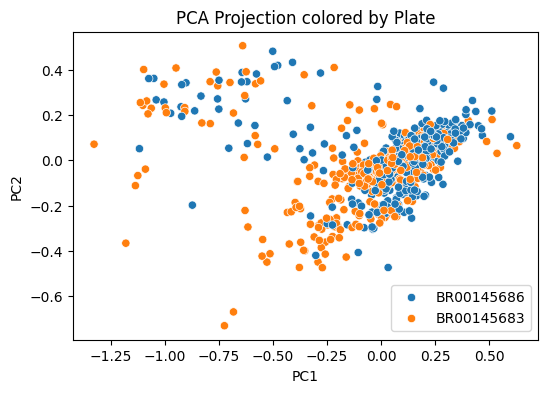

In [37]:
## non scaled data PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(norm_signal_filtered)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.index = norm_signal_filtered.index 

pca_df['Plate'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_plate_barcode']
pca_df['Compound'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_Compound']
pca_df['Concentration'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_compound_concentration']
pca_df= pca_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 0.2), loc='upper left')
plt.show()

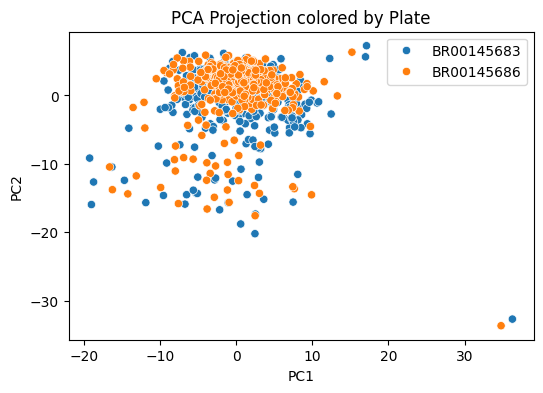

In [38]:
## scaled data PCA


scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.index = norm_signal_filtered.index 

pca_df['Plate'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_plate_barcode']
pca_df['Compound'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_Compound']
pca_df['Concentration'] = norm_signal.loc[norm_signal_filtered.index, 'Metadata_compound_concentration']


plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

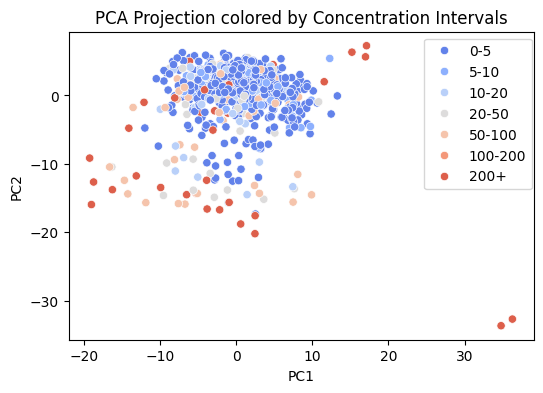

In [39]:
##scaled data PCA colored by concentration intervals

bins = [0, 5, 10, 20, 50, 100, 200, 300] 
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200+']  


pca_df['Concentration_Binned'] = pd.cut(pca_df['Concentration'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Concentration_Binned'], palette="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration Intervals")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
plt.show()

['Untreated' 'Compound' 'DMSO']


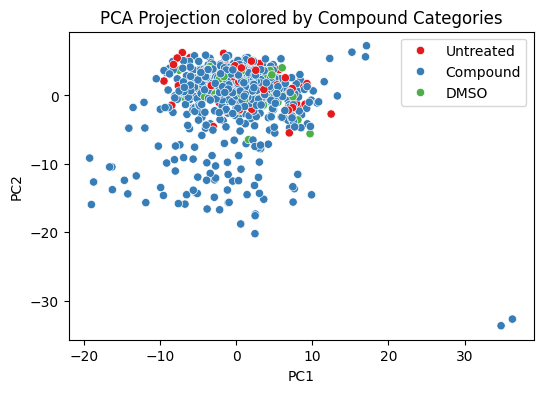

In [40]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Untreated' if x == 'UNTREATED' else 'Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



In [41]:
# UMAP projection of the scaled data

umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(scaled)

norm_signal["UMAP1"], norm_signal["UMAP2"] = umap_result[:, 0], umap_result[:, 1]


metadata_color =  "Metadata_plate_barcode"  #"Metadata_compound_concentration"  


plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="UMAP1", y="UMAP2", hue=norm_signal[metadata_color], style=norm_signal["Metadata_plate_barcode"],
    palette="tab10", data=norm_signal, alpha=0.7 )
plt.title("UMAP Projection Colored by Plate (Replicate)")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'

### Missing values and PC score across plates 

We start by calculating the percentage of missing values for each well on each plate. Then, we visualize this using a heatmap to see how missing data is distributed across different plates and wells.

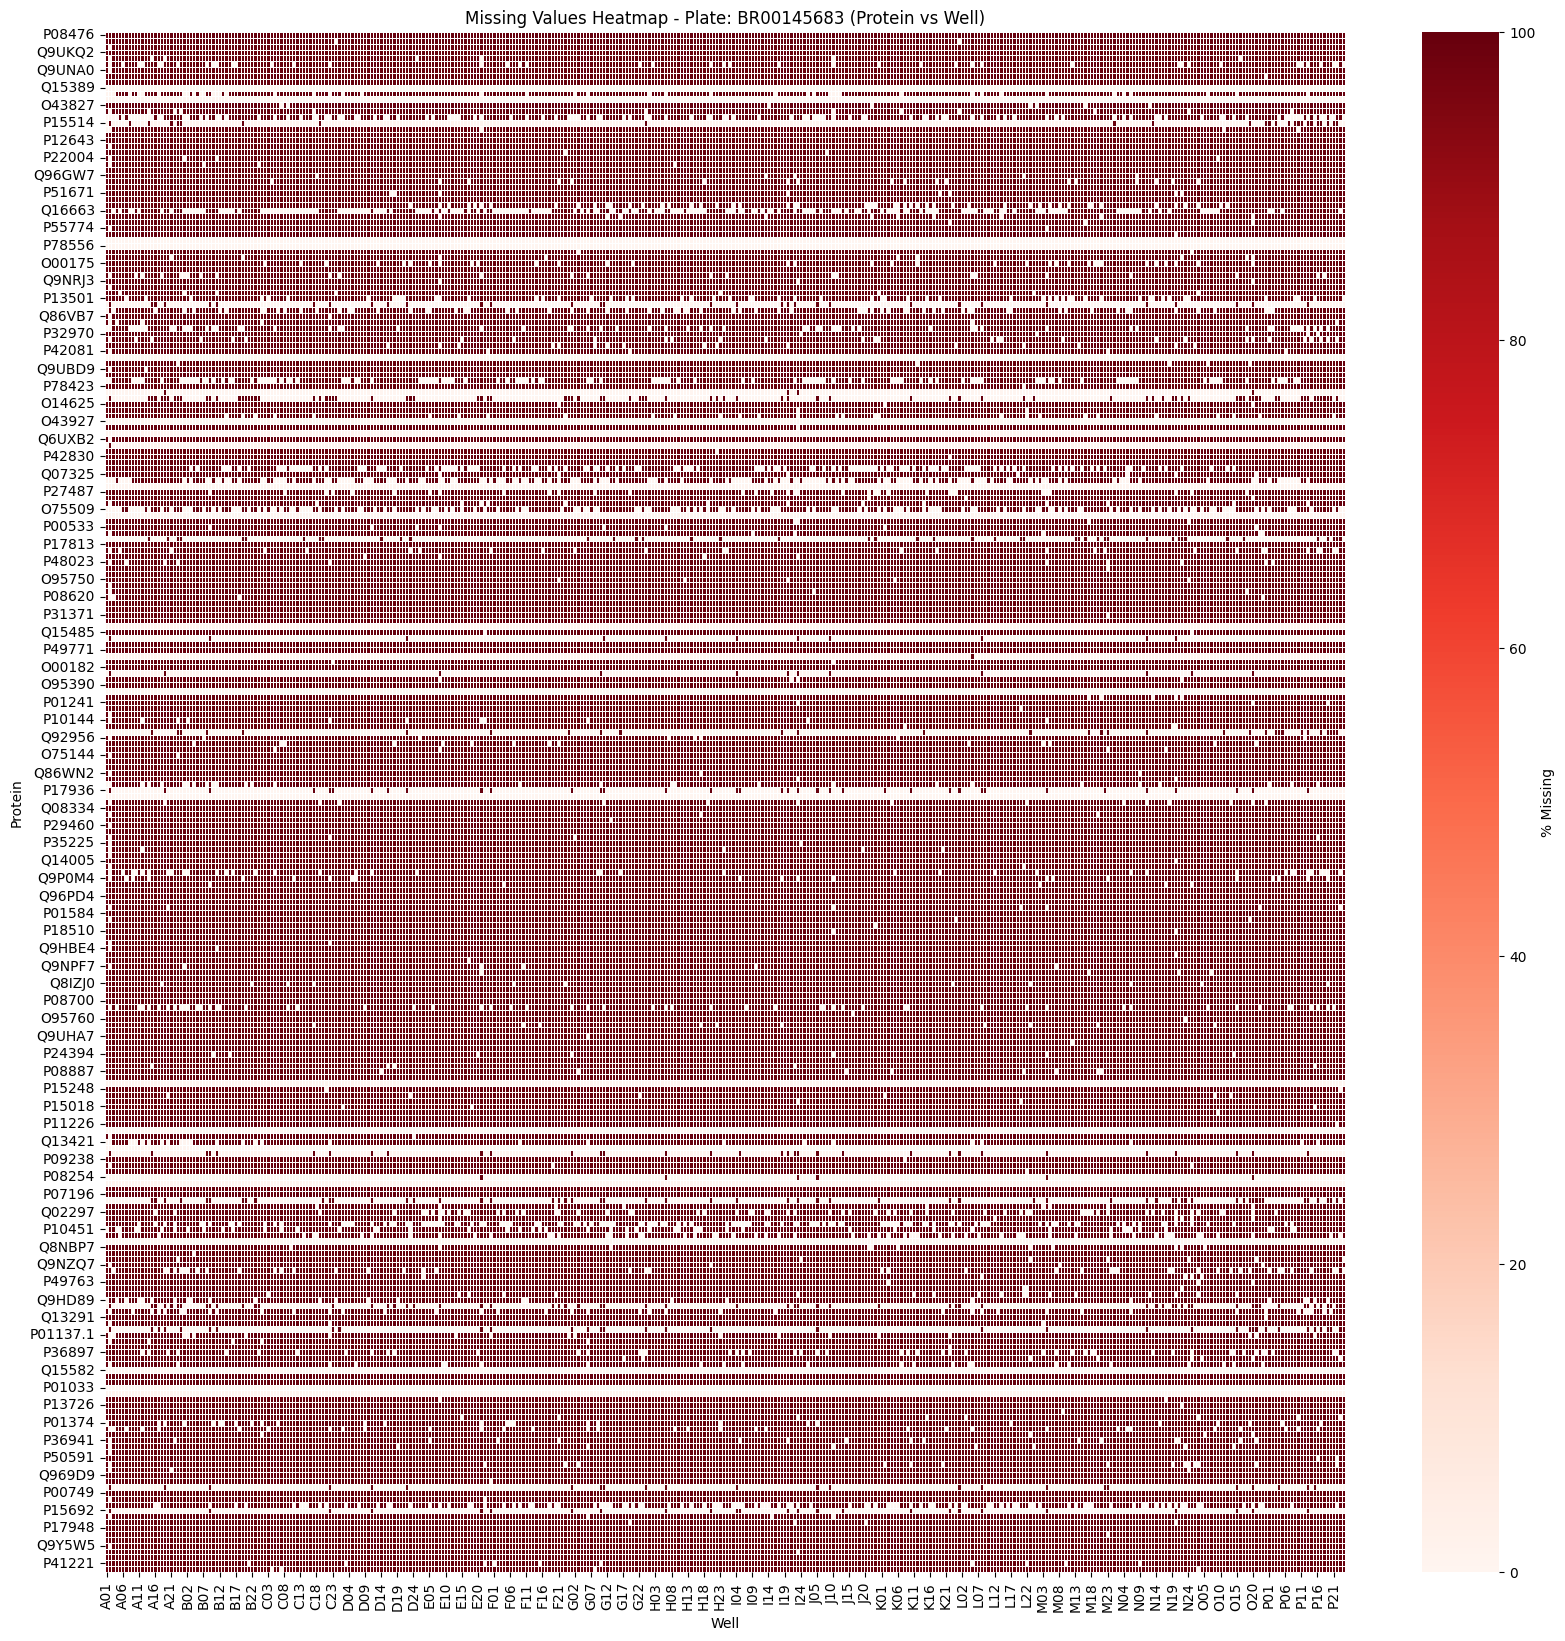

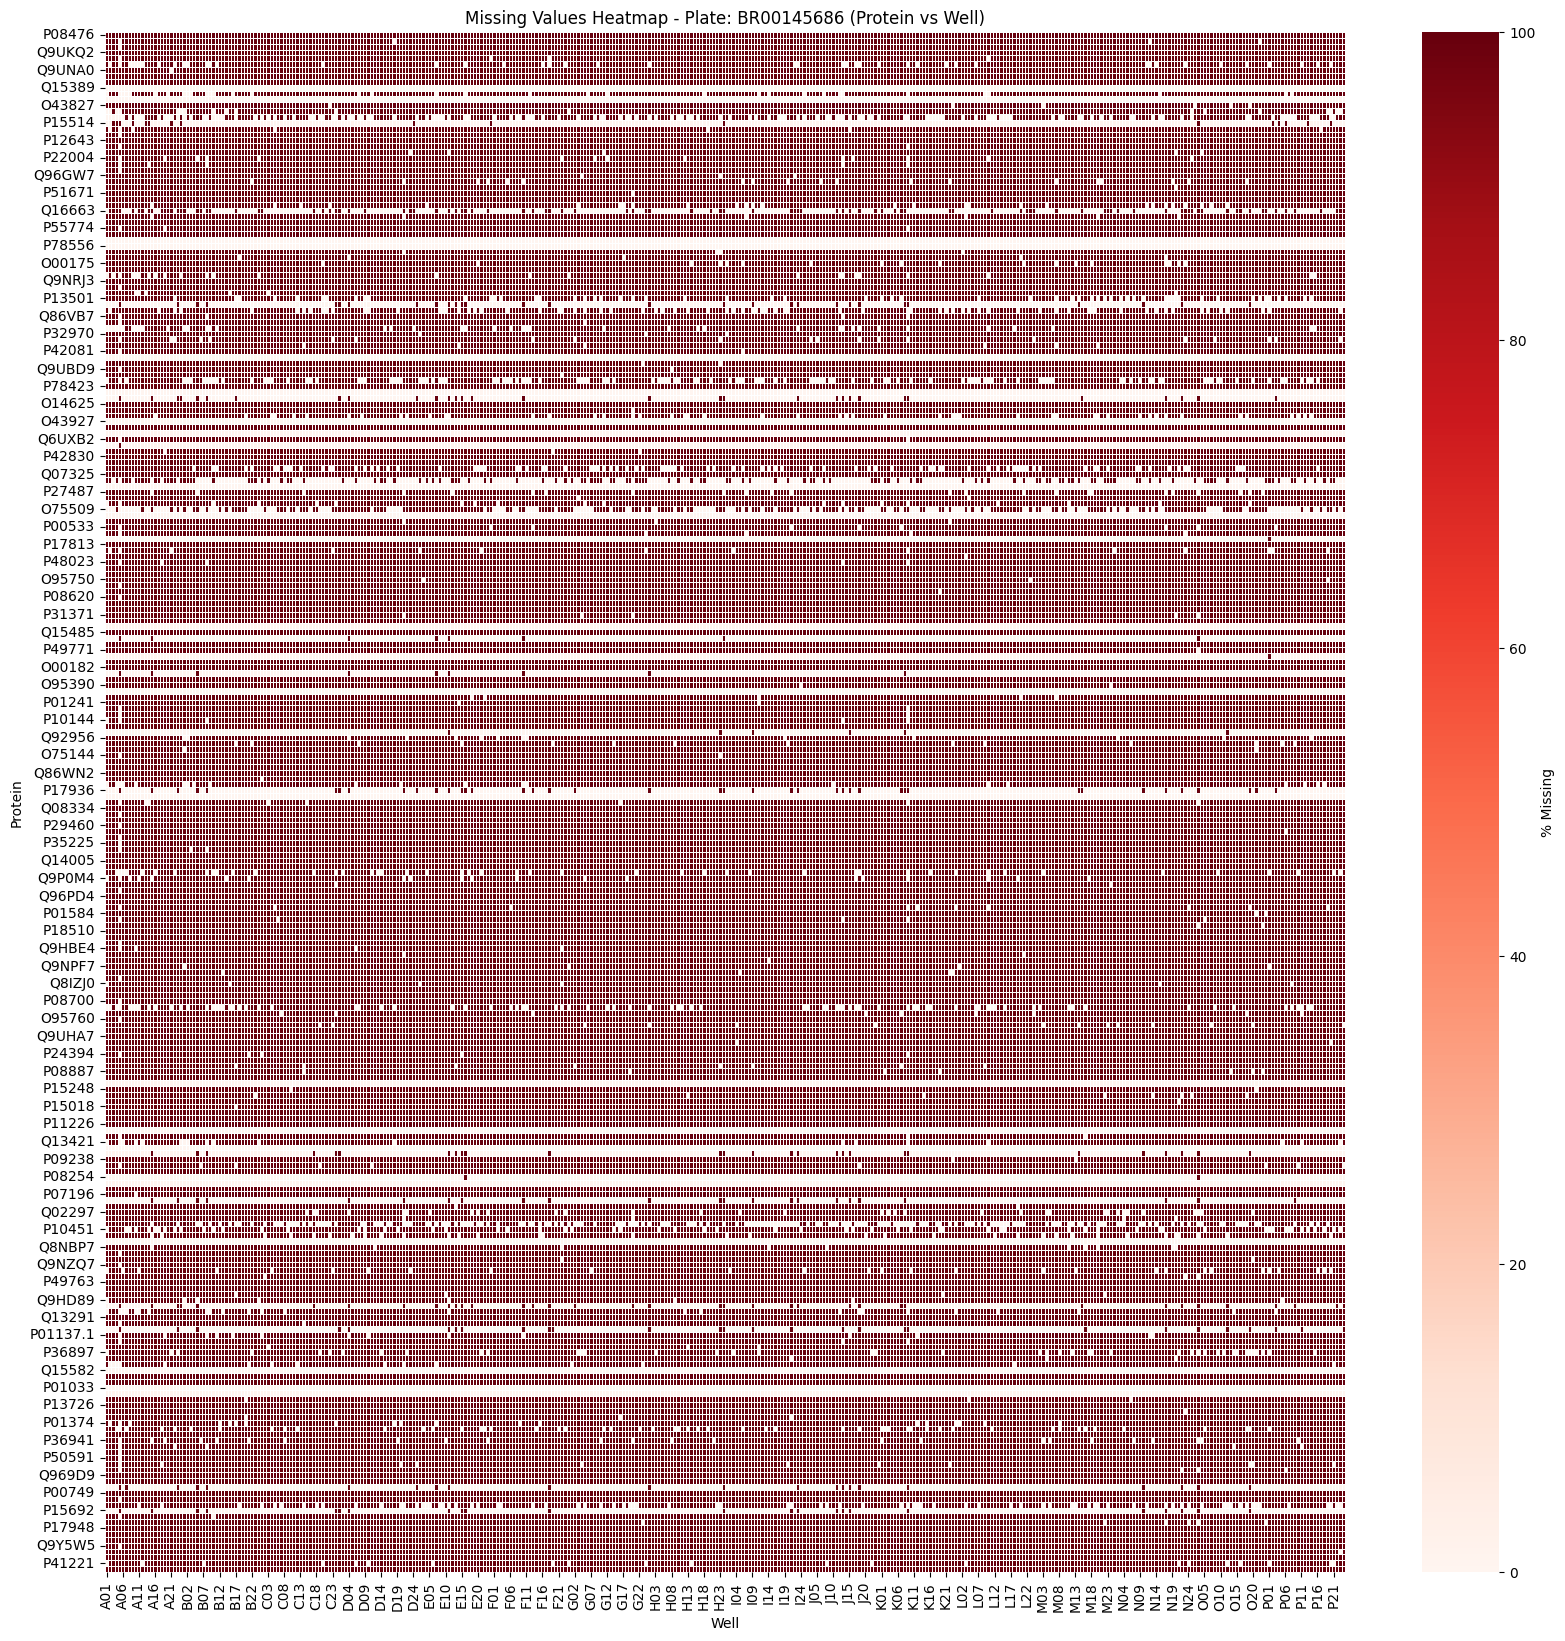

In [42]:
for plate in raw_data["Metadata_plate_barcode"].unique():
    # Create a DataFrame to store % missing values for each protein and well
    missing_values_well = pd.DataFrame(index=protein_cols, columns=raw_data["Metadata_well_id"].unique())

    # Loop through each well to calculate missing values
    for well in raw_data["Metadata_well_id"].unique():
        # Subset the data for the given plate and well
        subset = raw_data[(raw_data["Metadata_plate_barcode"] == plate) & 
                          (raw_data["Metadata_well_id"] == well)]

        # Calculate the missing values percentage for each protein column
        for protein in protein_cols:
            missing_percent = count_non_numeric(subset[protein])
            missing_values_well.loc[protein, well] = missing_percent

    # Convert the DataFrame to float for proper heatmap plotting
    missing_values_well = missing_values_well.astype(float)

    # Plot the heatmap for the current plate
    plt.figure(figsize=(20, 20))
    sns.heatmap(missing_values_well, cmap="Reds", annot=False, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Missing'})
    plt.title(f"Missing Values Heatmap - Plate: {plate} (Protein vs Well)")
    plt.xlabel("Well")
    plt.ylabel("Protein")
    plt.show()

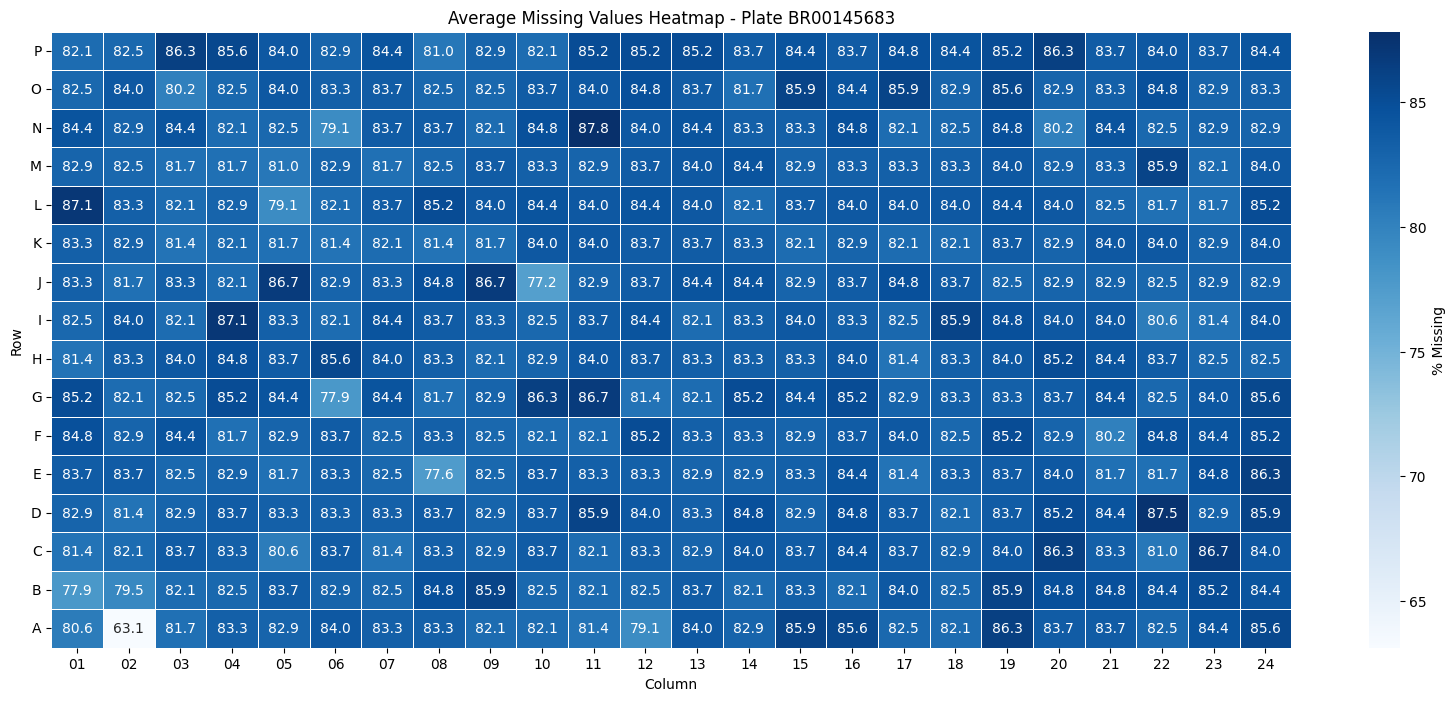

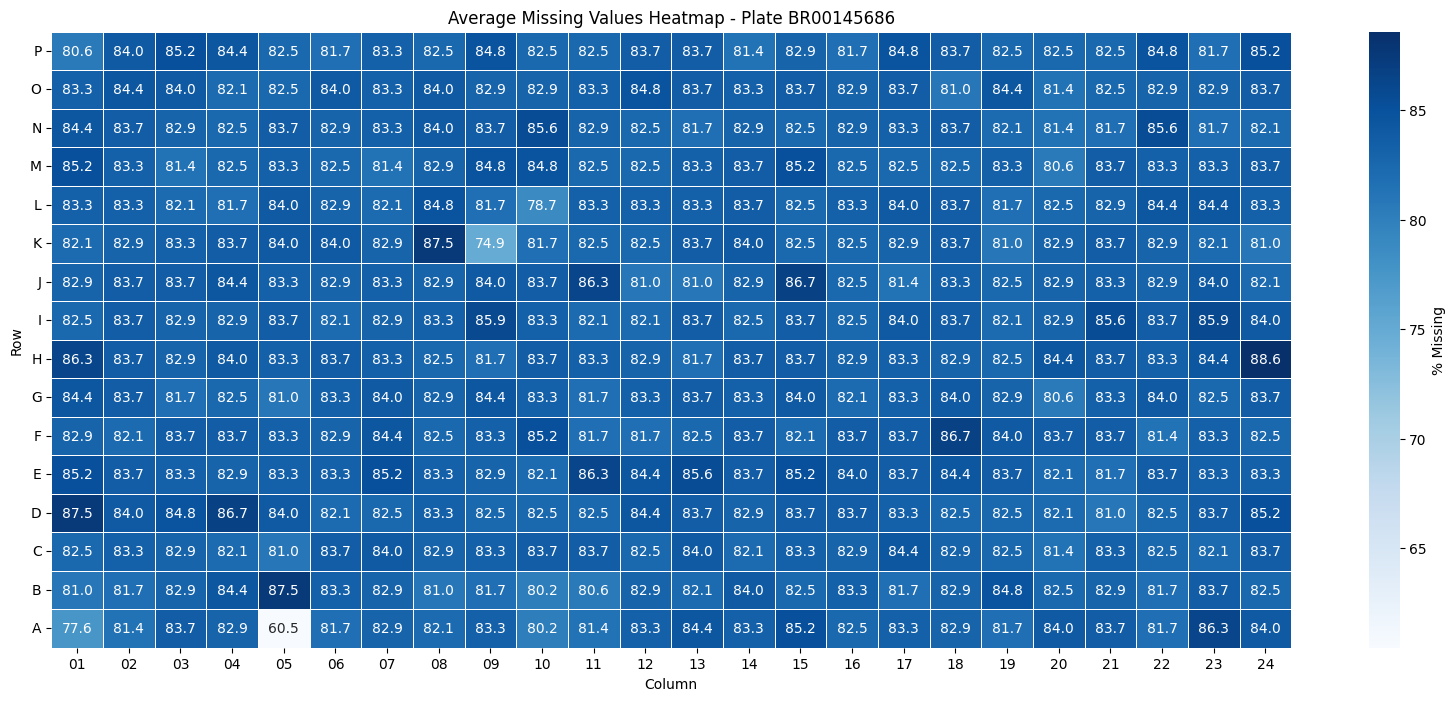

In [43]:
well_layout = pd.DataFrame(index=[chr(i) for i in range(65, 81)], columns=[str(i).zfill(2) for i in range(1, 25)])

missing_values_well = pd.DataFrame(index=well_layout.index, columns=well_layout.columns)

plates = raw_data["Metadata_plate_barcode"].unique()

for plate in plates:
    
    missing_values_df = pd.DataFrame(index=well_layout.index, columns=well_layout.columns)
    for row in well_layout.index:
        for col in well_layout.columns:
            well_id = f"{row}{col}" 
            well_data = raw_data[(raw_data["Metadata_plate_barcode"] == plate) & (raw_data["Metadata_well_id"] == well_id)]
            
            missing_percent = np.mean([count_non_numeric(well_data[protein]) for protein in protein_cols])
            missing_values_df.loc[row, col] = missing_percent


    missing_values_df = missing_values_df.astype(float)

    plt.figure(figsize=(20, 8))
    sns.heatmap(missing_values_df, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Missing'}, 
                xticklabels=missing_values_df.columns, yticklabels=missing_values_df.index, 
                cbar=True)


    plt.gca().invert_yaxis()
    plt.title(f"Average Missing Values Heatmap - Plate {plate}")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.yticks(rotation=360, ha='right')
    plt.show()

## Make scatterplots of replicates

In [ ]:
import polars as pl

pca_pl = pl.DataFrame(pca_df)

# first, filter out DMSO and UNTREATED
pca_pl = pca_pl.filter(~pl.col("Compound").is_in(list(compounds_with_single_concentration)))

# convert into long format
pca_melt = pca_pl.melt(
    id_vars = ["Compound", "Concentration", "Plate"],
    value_vars = ["PC1", "PC2"],
    variable_name = "PC",
    value_name = "Score"
)

# pivot to compare PCs across replicates
pc1 = pca_melt.filter(pl.col("PC") == "PC1").pivot(
    columns="Plate",
    index=["Compound", "Concentration"],
    values = "Score",
    aggregate_function = None
)

pc2 = pca_melt.filter(pl.col("PC") == "PC2").pivot(
    columns="Plate",
    index=["Compound", "Concentration"],
    values = "Score",
    aggregate_function = None
)